In [1]:
import sys

import constants
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from PyComplexHeatmap import *
from scipy.stats import pearsonr
from sklearn.cluster import KMeans

sys.path.insert(1, "../helper_functions")
from helper_functions import prepare_bulk

In [2]:
col = constants.COL

## Bulk

In [3]:
bulk195 = prepare_bulk("../../HIPSD_seq/data/p195_1MB_per_bin_calls_long.bed")
bulk63 = prepare_bulk("../../HIPSD_seq/data/p63_1MB_per_bin_calls_long.bed")

In [4]:
cut_chroms = bulk63[["chrom_num"]].copy()
cut_chroms.chrom_num = cut_chroms.chrom_num.astype(str)
cut_chroms.columns = ["chromosome"]
cut_chroms = cut_chroms.replace({"23": "X"})

## ATAC

In [5]:
cnvs = pd.read_csv(
    "../../HIPSD_seq/data/ATAC_epiAneufinder_CNVs.tsv.gz",
    sep=" ",
    index_col=0,
)
cnvs

,seq,start,end,cell-CCTTGGTCAGTGCTCG-1,cell-TTGGTCCAGGTCGGTA-1,cell-AGCCTCTCACCATTCC-1,cell-GTCCATCTCTAGTCGA-1,cell-TGATGCAGTGATTCCA-1,cell-CATAACGAGTATACCC-1,cell-ACTGCGGTCCATGACA-1,...,cell-CTTCTAACAGTGGTCC-1,cell-GCCTACTAGGGCATTG-1,cell-GCATTCCAGCGCGTTC-1,cell-ATTCGTTCAACGCAAG-1,cell-GAAGTCTAGTAGGTCG-1,cell-GGGTTATGTACGCCCA-1,cell-AATGGCTAGGCAAGCT-1,cell-GTCGTAAAGACAACGC-1,cell-CCATACCGTACGTATC-1,cell-GGGTGTCAGAGTAAGG-1
1,chr1,1000001,2000000,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,chr1,3000001,4000000,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,chr1,4000001,5000000,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,chr1,5000001,6000000,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5,chr1,6000001,7000000,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,chrX,134000001,135000000,1,1,1,0,1,1,1,...,1,1,1,1,0,1,1,1,0,1
2349,chrX,136000001,137000000,1,1,1,0,1,1,1,...,1,1,1,1,0,1,1,1,0,1
2350,chrX,145000001,146000000,1,1,1,0,1,1,1,...,1,1,1,1,0,1,1,1,0,1
2351,chrX,146000001,147000000,1,1,0,0,1,1,1,...,1,1,1,1,0,1,1,1,0,1


In [6]:
cnvs["pos"] = cnvs.apply(
    lambda row: f"{row['seq']}:{row['start']}-{row['end']+1}", axis=1
)
cnvs.drop(columns=["seq", "start", "end"], inplace=True)
cnvs.set_index("pos", inplace=True)
cnvs = cnvs.T
# setting value 1 to diploid
cnvs = cnvs + 1

In [7]:
cut_chroms = cut_chroms.loc[cnvs.columns]
cut_chroms

,chromosome
pos,
chr1:1000001-2000001,1
chr1:3000001-4000001,1
chr1:4000001-5000001,1
chr1:5000001-6000001,1
chr1:6000001-7000001,1
...,...
chrX:134000001-135000001,X
chrX:136000001-137000001,X
chrX:145000001-146000001,X


In [8]:
kmeans = KMeans(n_clusters=2, random_state=42)  # Number of clusters
kmeans.fit(cnvs)

KMeans(n_clusters=2, random_state=42)

In [9]:
labels = kmeans.labels_

In [10]:
df1 = pd.DataFrame(
    [
        cnvs.apply(
            lambda row: pearsonr(row, bulk195.loc[cut_chroms.index].CN)[0], axis=1
        ),
        cnvs.apply(
            lambda row: pearsonr(row, bulk63.loc[cut_chroms.index].CN)[0], axis=1
        ),
    ]
)

In [11]:
df1 = df1.T
df1.columns = ["bulk_p195", "bulk_p63"]

In [12]:
df1["clusters"] = labels
df1["clusters"] = df1["clusters"].replace(0, "Cluster 0")
df1["clusters"] = df1["clusters"].replace(1, "Cluster 1")

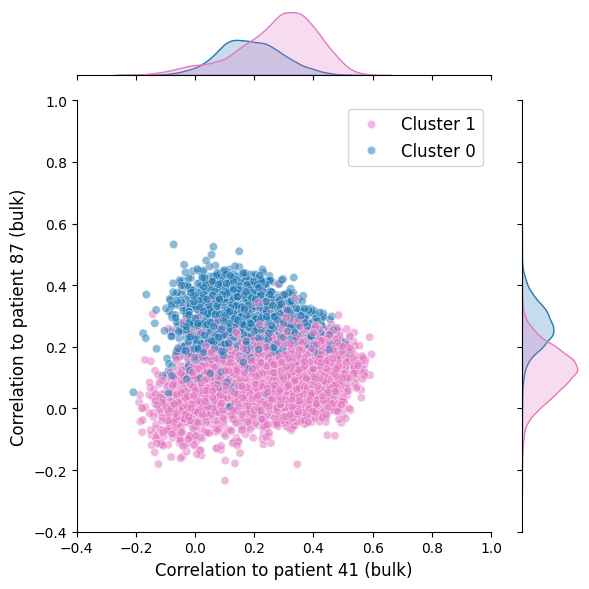

In [13]:
sns.jointplot(
    x="bulk_p63",
    y="bulk_p195",
    data=df1,
    alpha=0.5,
    hue="clusters",
    palette={
        "Cluster 1": sns.palettes.color_palette("tab10")[6],
        "Cluster 0": sns.palettes.color_palette("tab10")[0],
    },
)
plt.xlabel("Correlation to patient 41 (bulk)", fontsize=12)
plt.ylabel("Correlation to patient 87 (bulk)", fontsize=12)
plt.xlim(-0.4, 1)
plt.ylim(-0.4, 1)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("figures_rebuttal/correlation_atac.png", dpi=300)
plt.savefig("figures_rebuttal/correlation_atac.svg", dpi=300)

In [14]:
cut_chroms = bulk63[["chrom_num"]].copy()
cut_chroms.chrom_num = cut_chroms.chrom_num.astype(str)
cut_chroms.columns = ["chromosome"]
cut_chroms = cut_chroms.replace({"23": "X"})
cut_chroms = cut_chroms.loc[cnvs.columns]

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..


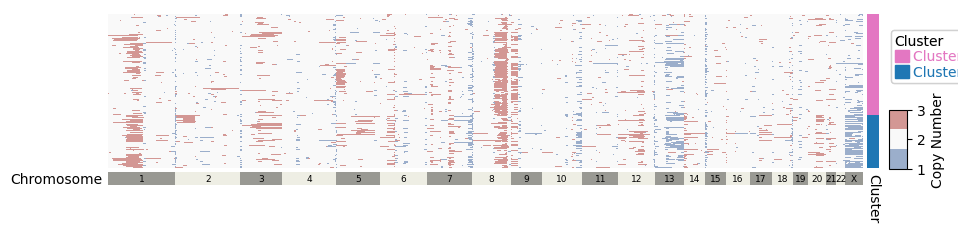

In [15]:
plt.figure(figsize=(10, 2))

newcmp = list(sns.color_palette("vlag", 3))
newcmp[1] = "#F9F9F9"
newcmp = ListedColormap(newcmp, "my_cmap3")

col_ha = HeatmapAnnotation(
    Chromosome=anno_simple(
        cut_chroms.chromosome, add_text=True, colors=col, text_kws={"color": "black"}
    ),
    plot_legend=False,
    axis=1,
    rasterized=True,
    label_side="left",
    verbose=0,
)
row_ha = HeatmapAnnotation(
    Cluster=anno_simple(
        df1.clusters,
        add_text=False,
        colors={
            "Cluster 1": sns.palettes.color_palette("tab10")[6],
            "Cluster 0": sns.palettes.color_palette("tab10")[0],
        },
    ),
    plot_legend=True,
    axis=0,
    rasterized=True,
    label_side="bottom",
)
cm1 = ClusterMapPlotter(
    data=cnvs[cut_chroms.index],
    row_dendrogram=False,  # set to False for the final heatmap
    show_rownames=False,
    show_colnames=False,
    bottom_annotation=col_ha,
    right_annotation=row_ha,
    row_cluster_metric="cityblock",
    row_cluster_method="ward",
    col_cluster=False,
    row_cluster=True,
    label="Copy Number",
    cmap=newcmp,
    rasterized=True,
    row_split=df1.clusters,
    row_split_gap=0,
    row_split_order=["Cluster 1", "Cluster 0"],
)
plt.savefig("figures_rebuttal/atac_mix_final.png", dpi=300)
plt.savefig("figures_rebuttal/atac_mix_final.svg", dpi=300)

## HIPSDR

In [17]:
cna = pd.read_csv("../../HIPSD_seq/data/CNVs_HIPSDR_filtered.csv.gz", index_col=0)
cna = cna.reindex(columns=cnvs.columns)
cna

pos,chr1:1000001-2000001,chr1:3000001-4000001,chr1:4000001-5000001,chr1:5000001-6000001,chr1:6000001-7000001,chr1:7000001-8000001,chr1:8000001-9000001,chr1:9000001-10000001,chr1:10000001-11000001,chr1:11000001-12000001,...,chrX:105000001-106000001,chrX:108000001-109000001,chrX:112000001-113000001,chrX:119000001-120000001,chrX:123000001-124000001,chrX:134000001-135000001,chrX:136000001-137000001,chrX:145000001-146000001,chrX:146000001-147000001,chrX:151000001-152000001
TTCAGGTAGTAAGAAC-1,4,4,4,4,4,4,4,4,4,4,...,3,3,3,2,2,2,2,2,2,2
TGCAGGCTCGGTTTGG-1,4,4,4,4,4,4,4,4,4,4,...,2,2,2,1,1,1,1,1,1,1
CCTTATGTCTAGCGAT-1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
TACTTCGTCGCCTAAG-1,4,4,4,4,4,4,4,4,4,4,...,2,3,3,3,3,3,3,3,3,3
AGGTATTGTAGGTTGC-1,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAAACTGGTAACCACA-1,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
ACGCAAGCACGTTACA-1,3,3,3,3,3,3,3,3,3,3,...,2,2,2,2,2,2,2,2,2,2
AATCCGTAGGTTTACA-1,3,3,3,3,3,3,3,3,3,3,...,2,2,2,2,2,2,2,2,2,2
TCCCGTTAGCTCAAAC-1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [18]:
kmeans = KMeans(n_clusters=2, random_state=42)  # Number of clusters
kmeans.fit(cna)

KMeans(n_clusters=2, random_state=42)

In [19]:
labels = kmeans.labels_

In [20]:
df1 = pd.DataFrame(
    [
        cna.apply(
            lambda row: pearsonr(row, bulk195.loc[cut_chroms.index].CN)[0], axis=1
        ),
        cna.apply(
            lambda row: pearsonr(row, bulk63.loc[cut_chroms.index].CN)[0], axis=1
        ),
    ]
)

In [21]:
df1 = df1.T
df1.columns = ["bulk_p195", "bulk_p63"]

In [22]:
df1["clusters"] = labels
df1["clusters"] = df1["clusters"].replace(0, "Cluster 0")
df1["clusters"] = df1["clusters"].replace(1, "Cluster 1")

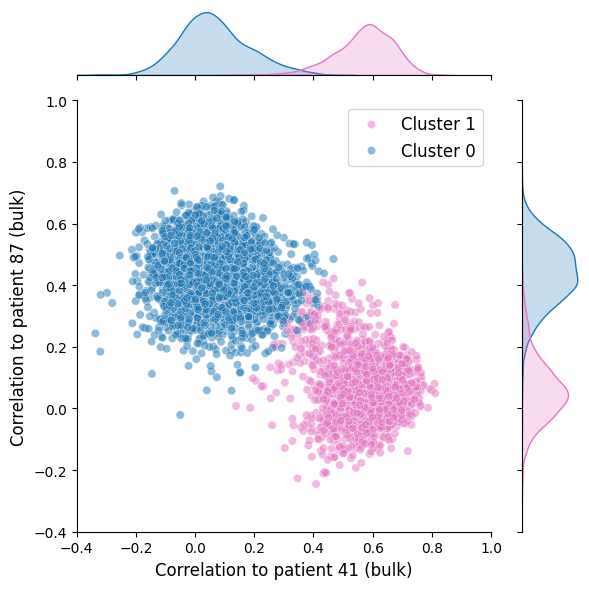

In [23]:
sns.jointplot(
    x="bulk_p63",
    y="bulk_p195",
    data=df1,
    alpha=0.5,
    hue="clusters",
    palette={
        "Cluster 1": sns.palettes.color_palette("tab10")[6],
        "Cluster 0": sns.palettes.color_palette("tab10")[0],
    },
)
plt.xlabel("Correlation to patient 41 (bulk)", fontsize=12)
plt.ylabel("Correlation to patient 87 (bulk)", fontsize=12)
plt.xlim(-0.4, 1)
plt.ylim(-0.4, 1)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("figures_rebuttal/correlation_hipsd_atac.png", dpi=300)
plt.savefig("figures_rebuttal/correlation_hipsd_atac.svg", dpi=300)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..


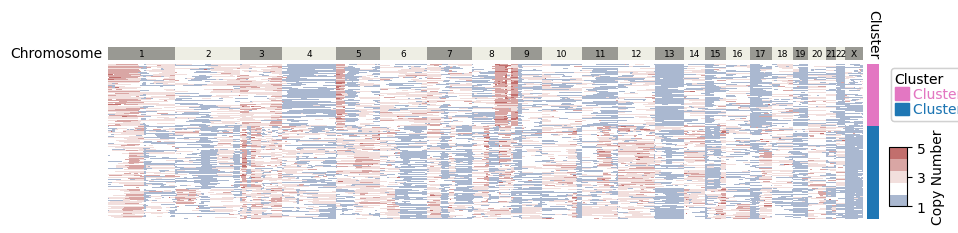

In [24]:
plt.figure(figsize=(10, 2))

newcmp = sns.color_palette("vlag", 6)[1:]
newcmp[1] = (1, 1, 1)
newcmp = ListedColormap(newcmp, "my_cmap3")

col_ha = HeatmapAnnotation(
    Chromosome=anno_simple(
        cut_chroms.chromosome, add_text=True, colors=col, text_kws={"color": "black"}
    ),
    plot_legend=False,
    axis=1,
    rasterized=True,
    label_side="left",
    verbose=0,
)
row_ha = HeatmapAnnotation(
    Cluster=anno_simple(
        df1.clusters,
        add_text=False,
        colors={
            "Cluster 1": sns.palettes.color_palette("tab10")[6],
            "Cluster 0": sns.palettes.color_palette("tab10")[0],
        },
    ),
    plot_legend=True,
    axis=0,
    rasterized=True,
)
cm1 = ClusterMapPlotter(
    data=cna[cut_chroms.index],
    row_dendrogram=False,
    show_rownames=False,
    show_colnames=False,
    top_annotation=col_ha,
    right_annotation=row_ha,
    row_cluster_metric="cityblock",
    row_cluster_method="ward",
    col_cluster=False,
    row_cluster=True,
    label="Copy Number",
    cmap=newcmp,
    rasterized=True,
    row_split=df1.clusters,
    row_split_gap=0,
    row_split_order=["Cluster 1", "Cluster 0"],
)

plt.savefig("figures_rebuttal/hipsd_atac_final.png", dpi=300)
plt.savefig("figures_rebuttal/hipsd_atac_final.svg", dpi=300)